# On Deep Learning-Based Channel Decoding

If you want to cite this notebook, please use the following bibtext entry:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

Running this example requires Keras installed with the Theano backend. For GPU support nvidia-docker is required. A Dockerfile is provided to employ this setup quickly.

Our simulation setup was inspired by material from http://radioml.org.


In [4]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Lambda, Reshape
from keras.layers import concatenate, Flatten, Input, Permute
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


# Parameters

In [0]:
results = {}

In [0]:
n = 4                       # antennas
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

nb_epoch = 2**16            # number of learning epochs
code = 'polar'              # type of code ('random' or 'polar')
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt((2*10**(train_SNR_Es/10)))

# Define NN model

In [0]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, Hest, sigma):
    w = K.random_normal(K.shape(x), mean=0.0)
    return tf.tensordot(tf.dtypes.cast(tf.sqrt(1/n)*sigma*x, tf.complex64), 
                        tf.dtypes.cast(Hest, tf.complex64), [-1, 0]) + \
              tf.dtypes.cast(w, tf.complex64)

def ber(y_true, y_pred):
    return K.mean(K.abs(y_true - K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model
  
def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    return K.sum(K.abs(y_true - K.round(y_pred)))

def flatten(x, flatHest):
    out1 = Reshape((N,), input_shape=(N//n,n), dtype=tf.complex64)(x)
    H_ = tf.constant(flatHest, dtype=tf.complex64)
    #H_ = Reshape((n*n,), input_shape=(n,n))(tf.constant(np.identity(n), dtype=tf.float32))
    duplicated = tf.map_fn(lambda ele : H_, out1)
    out3 = concatenate([out1, duplicated], axis=-1)
    out4 = concatenate([tf.real(out3), tf.imag(out3)], axis=-1)
    return tf.dtypes.cast(out4, dtype=tf.float32)

In [0]:
decoder_input_shape = 2*(n*n + N)
H = 1/2*(np.random.randn(n,n) + np.random.randn(n,n)*1j) #np.identity(n, dtype=np.float32)
Hest = H
flatHest = np.reshape(Hest,[n*n])

In [0]:
# Define modulator
modulator_layers = [Lambda(modulateBPSK, 
                          input_shape=(N,), output_shape=return_output_shape, name="modulator"),
                   Reshape((N//n,n), input_shape=(N,), name="serial-to-parallelizer")]
modulator = compose_model(modulator_layers)
modulator.compile(optimizer=optimizer, loss=loss)

# Define noise
noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma, 'Hest':Hest}, 
                       input_shape=(N//n,n), output_shape=return_output_shape, name="noise"),
               Lambda(flatten, arguments={'flatHest':flatHest}, 
                       input_shape=(N//n,n), output_shape=(decoder_input_shape,), name="flattener")]
noise = compose_model(noise_layers)
noise.compile(optimizer=optimizer, loss=loss)

# Define decoder 
decoder_layers = [Dense(design[0], activation='relu', input_shape=(decoder_input_shape,))]
for i in range(1,len(design)):
    decoder_layers.append(Dense(design[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))
decoder = compose_model(decoder_layers)
decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

# Define model
model_layers = modulator_layers + noise_layers + decoder_layers
model = compose_model(model_layers)
model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

# Data Generation

In [0]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [0]:
# Create all possible information words
d = np.zeros((2**k,k),dtype=bool)
for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])

# Create sets of all possible codewords (codebook)
if code == 'polar':   
    
    A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
    x = np.zeros((2**k, N),dtype=bool)
    u = np.zeros((2**k, N),dtype=bool)
    u[:,A] = d

    for i in range(0,2**k):
        x[i] = polar_transform_iter(u[i])

elif code == 'random':
    
    np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    x = np.random.randint(0,2,size=(2**k,N), dtype=bool)

# Train Neural Network

In [85]:
%%time 
model.summary()
history = model.fit(x, d, batch_size=batch_size, nb_epoch=nb_epoch, verbose=0, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
serial-to-parallelizer (Resh (None, 4, 4)              0         
_________________________________________________________________
noise (Lambda)               (None, 4, 4)              0         
_________________________________________________________________
flattener (Lambda)           (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


CPU times: user 11min 45s, sys: 44 s, total: 12min 29s
Wall time: 7min 7s


# Test NN

In [0]:
test_batch = 1000  
num_words = 100000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 10
SNR_points = 20

In [0]:
SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros(len(sigmas),dtype=int)
nb_bits = np.zeros(len(sigmas),dtype=int)

for i in range(0,len(sigmas)):

    for ii in range(0,np.round(num_words/test_batch).astype(int)):
        
        # Source
        np.random.seed(0)
        d_test = np.random.randint(0,2,size=(test_batch,k)) 

        # Encoder
        if code == 'polar':
            x_test = np.zeros((test_batch, N),dtype=bool)
            u_test = np.zeros((test_batch, N),dtype=bool)
            u_test[:,A] = d_test

            for iii in range(0,test_batch):
                x_test[iii] = polar_transform_iter(u_test[iii])

        elif code == 'random':
            x_test = np.zeros((test_batch, N),dtype=bool)
            for iii in range(0,test_batch):
                x_test[iii] = x[bin2int(d_test[iii])]

        # Modulator (BPSK)
        s_test = -2*x_test + 1
        
        # Serial to parallel
        p_test = np.reshape(s_test, [test_batch, N//n, n])
        assert((s_test[0,:] == p_test[0,:,:].flatten()).all())
        assert((s_test[3,:] == p_test[3,:,:].flatten()).all())
        assert((s_test[27,:] == p_test[27,:,:].flatten()).all())

        # Channel (AWGN)
        y_test = 1/sigmas[i]*np.dot(np.sqrt(1/n)*p_test, H) + np.random.standard_normal(p_test.shape)
        
        # Flattened
        f_test = np.reshape(y_test, (-1,N))
        new_shape = [f_test.shape[0],decoder_input_shape]
        z_test = np.zeros(new_shape)
        z_test[:,0:N] = np.real(f_test)
        z_test[:,N:n*n+N] = np.real(H).flatten()
        z_test[:,n*n+N:2*N+n*n] = np.imag(f_test)
        z_test[:,2*N + n*n:] = np.imag(H).flatten()

        # Decoder
        nb_errors[i] += decoder.evaluate(z_test, d_test, batch_size=test_batch, verbose=0)[1]
        nb_bits[i] += d_test.size

In [0]:
results[n] = (nb_errors/nb_bits)

# Plot Bit-Error-Rate

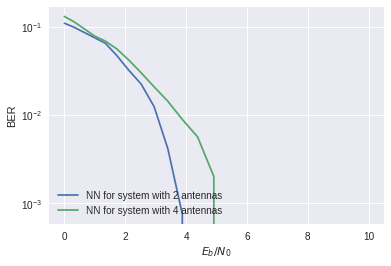

In [89]:
legend = []

for i in [2,4]:
  plt.plot(np.flip(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N),-1), results[i])
  legend.append('NN for system with %d antennas' %i) 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()

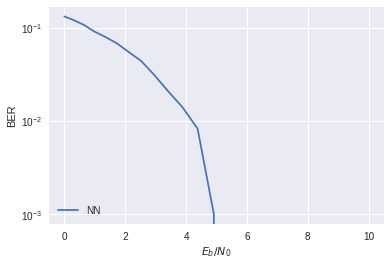

In [58]:
legend = []

#plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
plt.plot(np.flip(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N),-1), (nb_errors/nb_bits))
legend.append('NN') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()